In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pickle as pkl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
import copy

font = {'family' : 'sans serif',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
config_suffix = 'all_patches'

## Load DSC after Review

In [3]:
with open('cache/' + config_suffix + '_oracle_results.pkl', 'rb') as file2:
    oracle_results = pkl.load(file2)
    file2.close()

# true_dsc = pd.DataFrame(np.array([info_dict['true dice'] for info_dict in estimation_info]))
# uncali_est = pd.DataFrame(np.array([info_dict['est dice'] for info_dict in estimation_info]))

oracle_true = np.array([img_dict['true dsc curve'] for img_dict in oracle_results])
oracle_est = np.array([img_dict['est dsc curve'] for img_dict in oracle_results])

### How many patches need to be reviewed to attain a certain segmentation quality?

In [4]:
dice_thresh = None
overest_correction = [0.022, 0.022, 0.022] # Fit on validation set

def how_many_patches(row, tolerance, dice_thresh):
    # How many patches need to be re-annotated to satisfy dice_thresh?
    min_check = np.where(row >= dice_thresh + tolerance)[0]

    if np.min(min_check.shape) == 0:
        return -1

    else:
        return min_check[0]

In [5]:
individual_list = [] 
individual_true_list = [] 
# desired_dice_range = np.linspace(colmins_true[1], colmins_true.max(), 50)
desired_dice_range = np.linspace(0.88, 0.92, 3)

for dice_thresh, offset in zip(desired_dice_range, overest_correction):
    individual_list.append(np.apply_along_axis(how_many_patches, axis=1, arr=oracle_est, tolerance=offset, dice_thresh=dice_thresh))
    individual_true_list.append(np.apply_along_axis(how_many_patches, axis=1, arr=oracle_true, tolerance=offset, dice_thresh=dice_thresh))

In [6]:
# Set number of required patches to maximum for those images which could not 
# reach the desired target

individual_list_upper = copy.deepcopy(individual_list)
for lel in individual_list_upper:
    lel[lel == -1] = 14

individual_true_list_upper = copy.deepcopy(individual_true_list)
for lel in individual_true_list_upper:
    lel[lel == -1] = 14


In [7]:
# How many patches need to be reviewed on average?
mean_no_patches = [np.mean(arr[arr != -1]) for arr in individual_list_upper]

In [8]:
# Select final DSC after the specified number of patches has been reviewed
final_dice = [[] for _ in range(len(individual_list))]

for i in range(len(individual_list)):
    for row, no_patches_required in zip(oracle_true, individual_list[i]):
        final_dice[i].append(row[no_patches_required])

final_dice = np.array(final_dice)

In [9]:
# Quantify Distribution of DSCs
percentiles = [np.quantile(row, q=0.05, method='nearest') for row in final_dice]

In [11]:
x_shift = 0.15*np.random.uniform(-1, 1, 200)

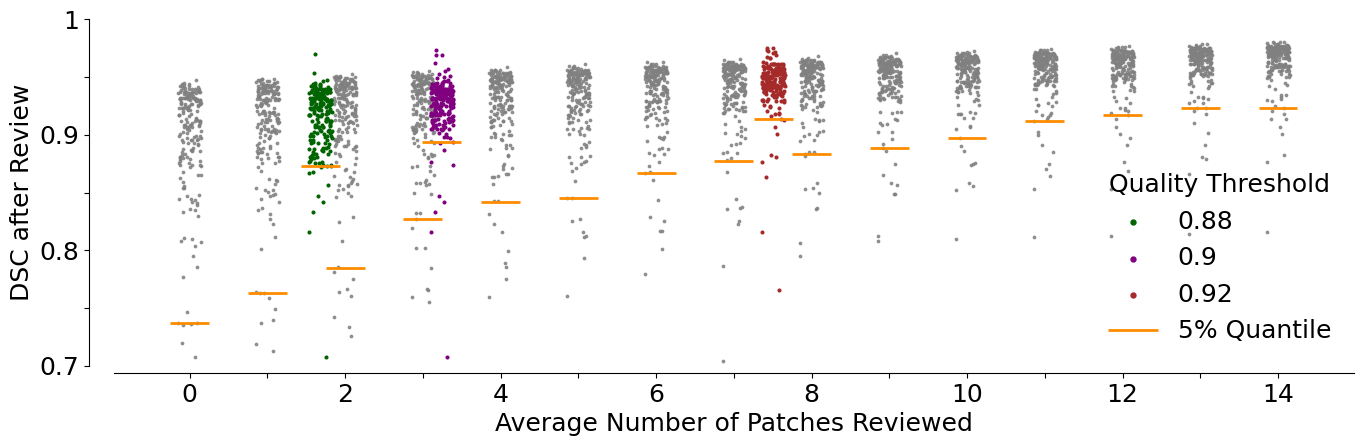

In [13]:
fig, ax = plt.subplots(figsize=(16,4.5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('axes', -0.02))
ax.spines['bottom'].set_position(('axes', -0.02))
ax.set_ylim(0.7, 1)
# ax.set_xlim(-0.35, 14.35)
#axi.set_ylim(, );
tick_locs = ax.get_yticks()
ax.set_yticks(tick_locs, [str(np.round(tick_loc*100, 0)) for tick_loc in tick_locs])

adaptive_labels = ['0.88', '0.9', '0.92']
adaptive_colours = ['darkgreen', 'purple', 'brown']


for i, row in enumerate(oracle_true.transpose()):
    ax.scatter(i + x_shift, row, s=3, c='grey', alpha=0.8)
    ax.hlines(np.quantile(row, q=0.05), xmin=i-1/4 , xmax=i+1/4,
                 colors='darkorange', linewidth=2)
    

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))    
ax.set_ylabel('DSC after Review')
ticklabels = [str(i) for i in range(15)]
for j in range(15):
    if j%2 != 0:
        ticklabels[j] = ''
ax.set_xticks(ticks=[i for i in range(0,15)],
              labels=ticklabels)


for i, row in enumerate(final_dice):
    #other_marker_bool = individual_list[i] == -1
    #other_marker_bool = np.isin(range(final_dice.shape[1]), below_threshold_idx[i])
    other_marker_bool = True
    x_values = np.array(mean_no_patches[i] + x_shift)
    ax.scatter(x_values[other_marker_bool], row[other_marker_bool], s=15,
                  marker='.', c=adaptive_colours[i])
    # second marker type
    ax.scatter(x_values[~other_marker_bool], row[~other_marker_bool], s=10,
                  marker='.', c=adaptive_colours[i])
    
    # draw hlines
    ax.hlines(y=percentiles[i], xmin=mean_no_patches[i] - 1/4,
                  xmax=mean_no_patches[i] + 1/4, colors='darkorange', linewidth=2)
    
for colour, label in zip(adaptive_colours, adaptive_labels):
    ax.scatter(2,2, marker='.', c=colour, label=label, s=50)

#ax.scatter(2,2, marker='D', facecolors='grey', edgecolors='grey', 
#               label='Estimation Below Target')

ax.hlines(0, xmin=i-1/4 , xmax=i+1/4, colors='darkorange', linewidth=2,
             label='5% Quantile')

ax.legend(loc='lower right', title='Quality Threshold', markerscale=1,
          frameon=False)
ax.set_xlabel('Average Number of Patches Reviewed')

ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))   
ax.set_yticks(ticks=np.arange(0.7,1, 0.05),
              labels=['0.7', '', '0.8', '', '0.9', '', '1'])

#fig.savefig('fig/efficient.png', bbox_inches='tight', dpi=200)